In [1]:
# If you haven't installed the bwb package yet, run the following command
# !pip install git+https://github.com/ottomossei/bwb
import warnings
warnings.simplefilter('ignore')

## import modules

In [2]:
import numpy as np
from bwb.db import LocalDB
import bwb.basicstrategy as bst
import bwb.indicator as indicator

Loading BokehJS ...

## Load candlestick

In [3]:
issue = 'AAPL'
d = LocalDB()
candle = d.loader(issue, start = '2020-01-01', end = '2020-05-01')
candle

AAPL


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.207466,135480400.0
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.486023,146322800.0
2020-01-06,73.447502,74.989998,73.187500,74.949997,74.071579,118387200.0
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.723213,108872000.0
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.909149,132079200.0
...,...,...,...,...,...,...
2021-07-23,147.550003,148.720001,146.919998,148.559998,148.559998,71361600.0
2021-07-26,148.270004,149.830002,147.699997,148.990005,148.990005,72269700.0
2021-07-27,149.119995,149.210007,145.550003,146.770004,146.770004,103580300.0


## Select basic strategy

In [4]:
# RCI Cross Strategy
strategy = bst.RCICross
strategy.candle = candle
params = strategy.base_indicator_params()
params

{'span': array([ 7,  8,  9, 21, 23, 26, 42, 45, 48, 52]),
 'buy_ratio': array([-100,  -90,  -80,  -70]),
 'sell_ratio': array([ 70,  80,  90, 100])}

## backtest of all parameter

In [5]:
ef, i = np.zeros(len(params['span'])*len(params['buy_ratio'])*len(params['sell_ratio'])), 0
best_p1, best_p2, best_p3 = 0, 0, 0

for p1 in params['span']:
        for p2 in params['buy_ratio']:
                for p3 in params['sell_ratio']:
                        strategy.indicator_params = {'span':p1, 'buy_ratio':p2, 'sell_ratio':p3}
                        tester = bst.Btest(strategy)
                        output = tester.run()
                        ef[i] = output['Equity Final [$]']
                        i += 1
                        if ef.max() > output['Equity Final [$]']:
                                best_p1 = p1
                                best_p2 = p2
                                best_p3 = p3
print(best_p1, best_p2, best_p3)

52 -70 100


## best parameter

In [6]:
strategy.indicator_params = {'span':best_p1, 'buy_ratio':best_p2, 'sell_ratio':best_p3}
output = d.runsaver(strategy)
output

Start                     2020-01-02 00:00:00
End                       2021-07-29 00:00:00
Duration                    574 days 00:00:00
Exposure Time [%]                   85.390428
Equity Final [$]                   2323.03345
Equity Peak [$]                   2389.753421
Return [%]                         132.303345
Buy & Hold Return [%]               93.960375
Return (Ann.) [%]                   70.748786
Volatility (Ann.) [%]               54.916344
Sharpe Ratio                         1.288301
Sortino Ratio                         3.54817
Calmar Ratio                         3.493349
Max. Drawdown [%]                  -20.252425
Avg. Drawdown [%]                   -4.109264
Max. Drawdown Duration      162 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                      98.658217
Worst Trade [%]                     17.729622
Avg. Trade [%]                    

## Show with mplfinance

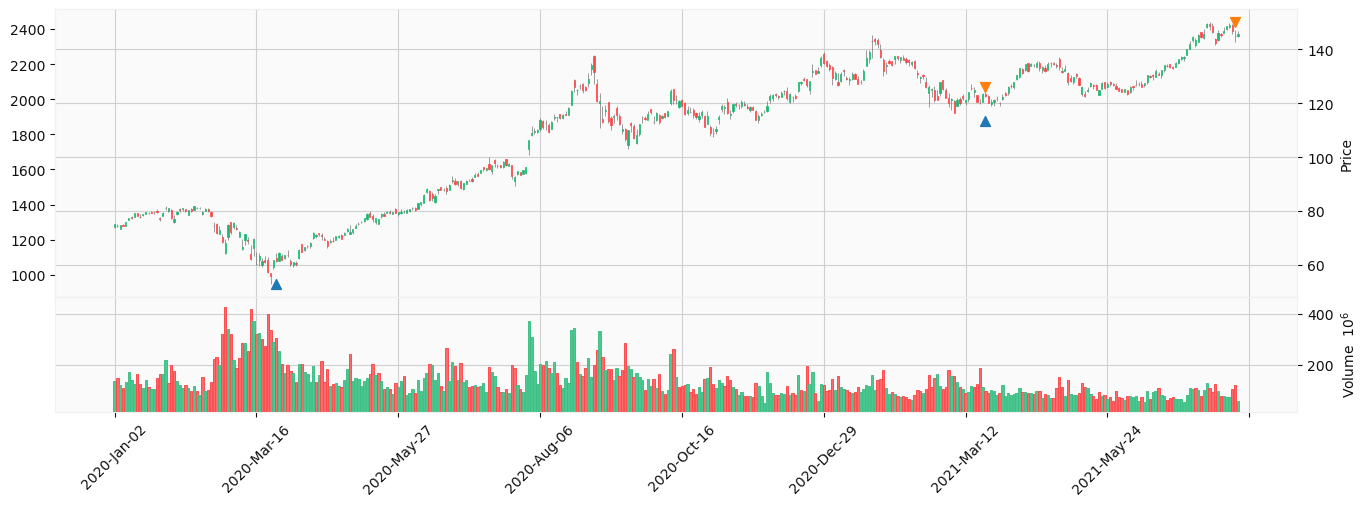

In [7]:
import mplfinance as mpf
import pandas as pd
buy = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['EntryBar']]*0.95, index=output['_equity_curve'].index)
sell = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['ExitBar']]*1.05, index=output['_equity_curve'].index)
# Show with Jupyter Notebook
apds = [mpf.make_addplot(buy,type='scatter',markersize=50,marker='^'),
        mpf.make_addplot(sell,type='scatter',markersize=50,marker='v')]

mpf.plot(candle, type='candle', figratio=(12,4),
         volume=True, style='yahoo', addplot=apds)

## Equity data

In [8]:
print(output['_equity_curve'])

                 Equity  DrawdownPct DrawdownDuration
2020-01-02  1000.000000     0.000000              NaT
2020-01-03  1000.000000     0.000000              NaT
2020-01-06  1000.000000     0.000000              NaT
2020-01-07  1000.000000     0.000000              NaT
2020-01-08  1000.000000     0.000000              NaT
...                 ...          ...              ...
2021-07-23  2380.313480     0.003950              NaT
2021-07-26  2387.193607     0.001071              NaT
2021-07-27  2351.673587     0.015935              NaT
2021-07-28  2323.033450     0.027919              NaT
2021-07-29  2323.033450     0.027919          15 days

[397 rows x 3 columns]


## Trade data

In [9]:
print(output['_trades'])

   Size  EntryBar  ExitBar  EntryPrice   ExitPrice         PnL  ReturnPct  \
0    16        57      307   61.683832  122.540001  973.698701   0.986582   
1    16       307      395  123.146574  144.979996  349.334749   0.177296   

   EntryTime   ExitTime Duration  
0 2020-03-25 2021-03-23 363 days  
1 2021-03-23 2021-07-28 127 days  
